# Explorative Datenanalyse für mehrere Datensätze

Dieses Notebook analysiert 4 Datensätze mit unterschiedlichen Strukturen:
- Datensatz 1: Hat Ordner für Annotationen und Bilder
- Datensätze 2-4: Haben Test-, Train- und Valid-Ordner mit XML-Annotationen im VOC-Format

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# Seaborn-Stil festlegen
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Pfad zu den Datensätzen definieren
root_dir = Path(os.getcwd()).parent.parent  # Annahme: Notebook ist in notebooks/eda
data_dir = root_dir / 'data'

# Prüfen, ob das Datenverzeichnis existiert
if not data_dir.exists():
    print(f"Datenverzeichnis nicht gefunden unter {data_dir}")
else:
    print(f"Datenverzeichnis gefunden unter {data_dir}")

Datenverzeichnis gefunden unter c:\Users\fabud\Documents\GitHub\dlbs-mc-oliver-fabian\data


In [3]:
# Funktion zum Finden aller XML-Dateien in den Datensätzen
def find_xml_files():
    xml_files = []
    dataset_info = {}
    
    # Datensatz 1 verarbeiten (annotations/images Struktur)
    ds1_path = data_dir / 'dataset_1'
    if ds1_path.exists():
        annotations_path = ds1_path / 'annotations'
        if annotations_path.exists():
            ds1_xml = list(annotations_path.glob('**/*.xml'))
            xml_files.extend(ds1_xml)
            dataset_info['dataset_1'] = {
                'path': ds1_path,
                'xml_count': len(ds1_xml),
                'structure': 'annotations/images'
            }
    
    # Datensätze 2-4 verarbeiten (test/train/valid Struktur)
    for ds_num in range(2, 5):
        ds_path = data_dir / f'dataset_{ds_num}'
        if ds_path.exists():
            ds_xml = []
            for split in ['train', 'test', 'valid']:
                split_path = ds_path / split
                if split_path.exists():
                    # Suche nach XMLs direkt im Split-Ordner oder im Annotations-Unterordner
                    xml_in_split = list(split_path.glob('*.xml'))
                    xml_in_annotations = list((split_path / 'annotations').glob('*.xml')) if (split_path / 'annotations').exists() else []
                    
                    ds_xml.extend(xml_in_split)
                    ds_xml.extend(xml_in_annotations)
            
            xml_files.extend(ds_xml)
            dataset_info[f'dataset_{ds_num}'] = {
                'path': ds_path,
                'xml_count': len(ds_xml),
                'structure': 'test/train/valid'
            }
    
    return xml_files, dataset_info

In [4]:
# Alle XML-Dateien finden
xml_files, dataset_info = find_xml_files()

# Datensatzinformationen anzeigen
print(f"{len(xml_files)} XML-Dateien in {len(dataset_info)} Datensätzen gefunden")
for ds_name, info in dataset_info.items():
    print(f"{ds_name}: {info['xml_count']} XML-Dateien, Struktur: {info['structure']}")

5304 XML-Dateien in 4 Datensätzen gefunden
dataset_1: 3686 XML-Dateien, Struktur: annotations/images
dataset_2: 1275 XML-Dateien, Struktur: test/train/valid
dataset_3: 258 XML-Dateien, Struktur: test/train/valid
dataset_4: 85 XML-Dateien, Struktur: test/train/valid


## Bounding-Box-Analyse

Analyse der Größe und Position von Bounding-Boxen aus den XML-Annotationen über alle Datensätze hinweg.

In [5]:
def analyze_bounding_boxes():
    """
    Analysiert die Größe und Position der Bounding-Boxen aus den XML-Annotationen über alle Datensätze hinweg.
    """
    if not xml_files:
        print("Keine XML-Dateien gefunden!")
        return
    
    bbox_data = []
    class_distribution = Counter()
    dataset_distribution = {}
    
    for xml_path in xml_files:
        # Bestimmen, zu welchem Datensatz diese Datei gehört
        dataset_name = str(xml_path).split(os.sep + 'data' + os.sep)[1].split(os.sep)[0] if 'data' in str(xml_path) else 'unbekannt'
        
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Bildgrößeninformationen abrufen
            img_width = img_height = None
            size_elem = root.find('size')
            if size_elem is not None:
                width_elem = size_elem.find('width')
                height_elem = size_elem.find('height')
                img_width = int(width_elem.text) if width_elem is not None else None
                img_height = int(height_elem.text) if height_elem is not None else None
            
            for obj in root.findall('object'):
                class_name = obj.find('name').text if obj.find('name') is not None else 'unbekannt'
                class_distribution[class_name] += 1
                
                # Datensatz-Klassenverteilung aktualisieren
                if dataset_name not in dataset_distribution:
                    dataset_distribution[dataset_name] = Counter()
                dataset_distribution[dataset_name][class_name] += 1
                
                bnd = obj.find('bndbox')
                if bnd is not None:
                    xmin = int(bnd.find('xmin').text)
                    ymin = int(bnd.find('ymin').text)
                    xmax = int(bnd.find('xmax').text)
                    ymax = int(bnd.find('ymax').text)
                    
                    width = xmax - xmin
                    height = ymax - ymin
                    area = width * height
                    aspect = width / height if height > 0 else 0
                    
                    # Relative Größen berechnen, wenn Bilddimensionen verfügbar sind
                    rel_width = width / img_width if img_width else None
                    rel_height = height / img_height if img_height else None
                    rel_area = rel_width * rel_height if rel_width and rel_height else None
                    
                    center_x = (xmin + xmax) / 2
                    center_y = (ymin + ymax) / 2
                    
                    bbox_data.append({
                        'file': os.path.basename(str(xml_path)),
                        'dataset': dataset_name,
                        'class': class_name,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax,
                        'width': width,
                        'height': height,
                        'area': area,
                        'aspect_ratio': aspect,
                        'rel_width': rel_width,
                        'rel_height': rel_height,
                        'rel_area': rel_area,
                        'center_x': center_x,
                        'center_y': center_y,
                        'img_width': img_width,
                        'img_height': img_height
                    })
        except Exception as e:
            print(f"Fehler beim Parsen der XML-Datei {xml_path}: {e}")
    
    if not bbox_data:
        print("Keine gültigen Bounding-Box-Daten gefunden!")
        return None, None, None
    
    # In DataFrame konvertieren
    bbox_df = pd.DataFrame(bbox_data)
    
    return bbox_df, class_distribution, dataset_distribution

In [6]:
# Bounding-Box-Analyse durchführen
bbox_df, class_distribution, dataset_distribution = analyze_bounding_boxes()

if bbox_df is not None:
    print(f"Gesamtzahl der Bounding-Boxen: {len(bbox_df)}")
    
    # Grundlegende Statistiken anzeigen
    print("\nBounding-Box-Statistiken:")
    print(bbox_df[['width', 'height', 'area', 'aspect_ratio']].describe())
    
    # Klassen pro Datensatz
    print("\nKlassenverteilung über Datensätze hinweg:")
    for dataset, classes in dataset_distribution.items():
        print(f"\n{dataset}:")
        for cls, count in classes.most_common():
            print(f"  {cls}: {count}")
    
    # Gesamte Klassenverteilung
    print("\nGesamte Klassenverteilung:")
    for cls, count in class_distribution.most_common():
        print(f"{cls}: {count}")

Gesamtzahl der Bounding-Boxen: 6216

Bounding-Box-Statistiken:
             width       height           area  aspect_ratio
count  6216.000000  6216.000000    6216.000000   6216.000000
mean    156.084138   161.167954   34971.191763      1.074864
std     109.161947   110.343873   55420.663288      0.596506
min      16.000000    18.000000     496.000000      0.135647
25%      79.000000    88.000000    7143.000000      0.751150
50%     130.000000   134.000000   15480.000000      0.979592
75%     199.000000   199.000000   38178.000000      1.210898
max     640.000000   640.000000  409600.000000      6.736842

Klassenverteilung über Datensätze hinweg:

dataset_1:
  dog: 2498
  cat: 1189

dataset_2:
  bird: 1223
  dog: 838

dataset_3:
  Abrador: 128
  Shiba-Inu: 121
  Chihuahua: 113

dataset_4:
  dog: 80
  persons: 16
  car: 9
  cat: 1

Gesamte Klassenverteilung:
dog: 3416
bird: 1223
cat: 1190
Abrador: 128
Shiba-Inu: 121
Chihuahua: 113
persons: 16
car: 9


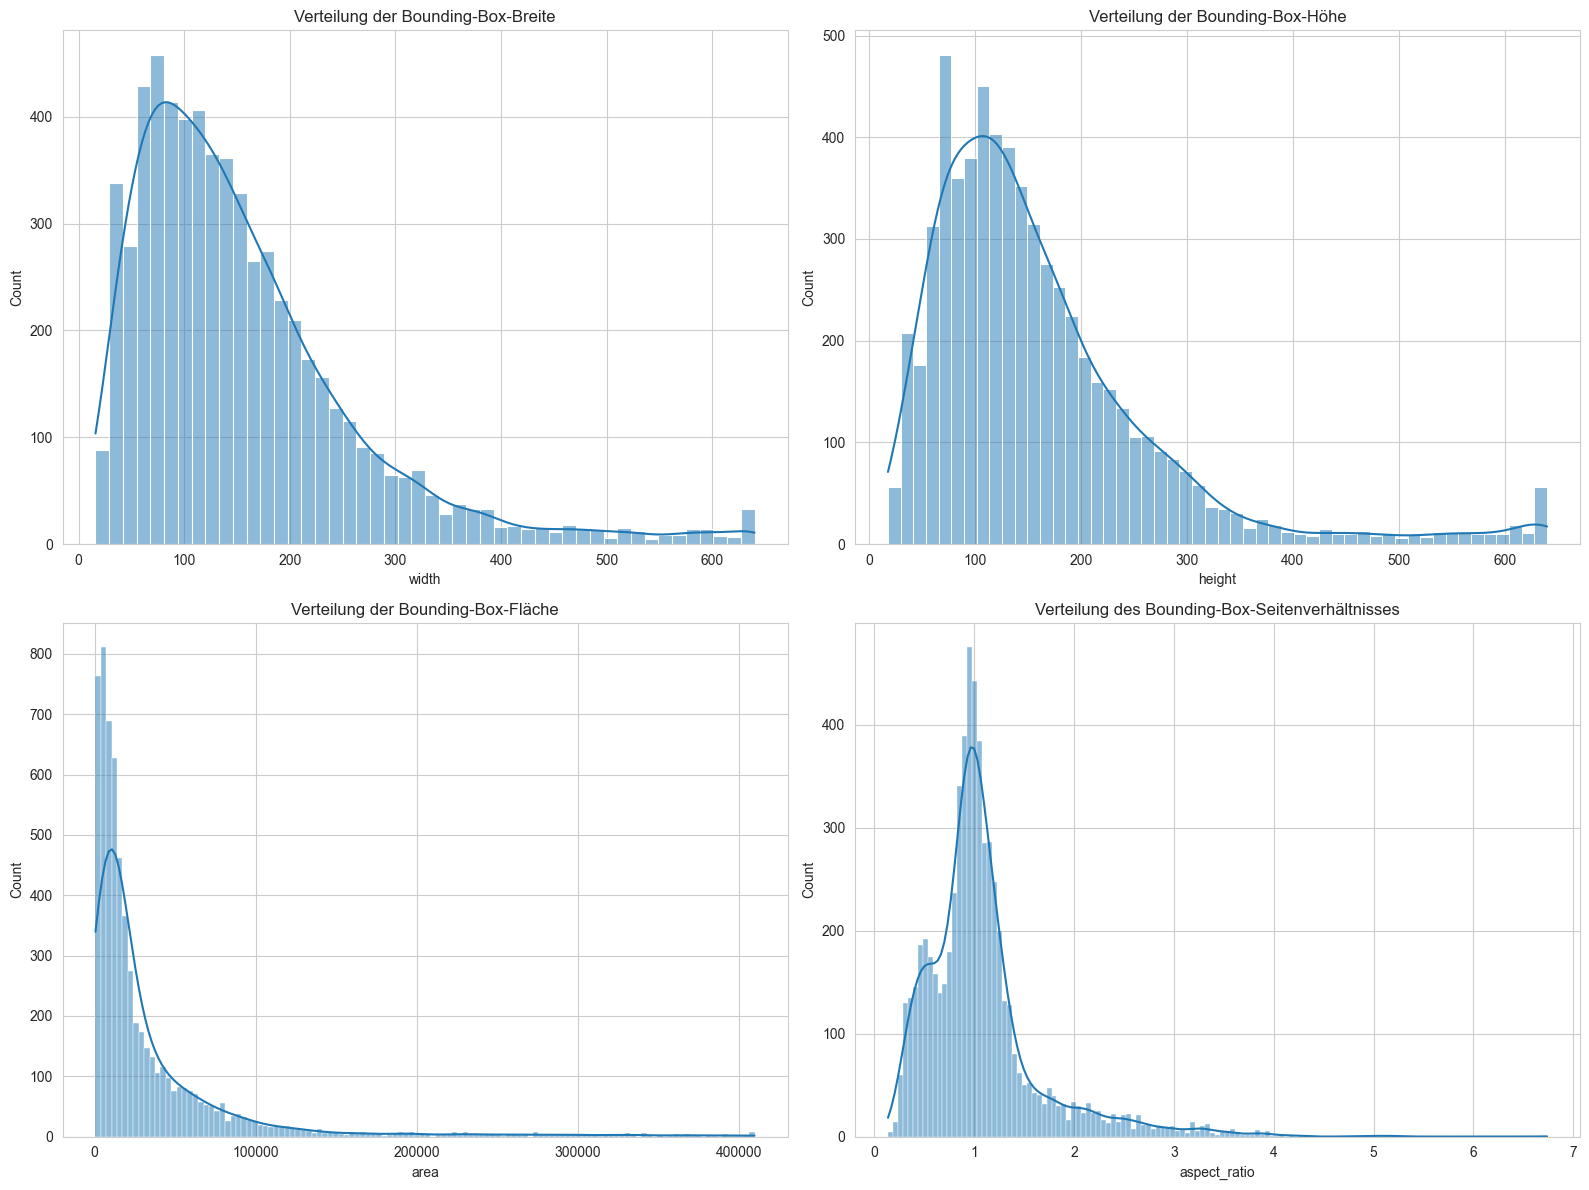

In [7]:
# Visualisierungen für Bounding-Box-Statistiken
if bbox_df is not None:
    # 1. Histogramme der Bounding-Box-Abmessungen
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Breite
    sns.histplot(bbox_df['width'], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Verteilung der Bounding-Box-Breite')
    
    # Höhe
    sns.histplot(bbox_df['height'], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Verteilung der Bounding-Box-Höhe')
    
    # Fläche
    sns.histplot(bbox_df['area'], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Verteilung der Bounding-Box-Fläche')
    
    # Seitenverhältnis
    sns.histplot(bbox_df['aspect_ratio'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Verteilung des Bounding-Box-Seitenverhältnisses')
    
    plt.tight_layout()
    plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\2531898018.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\2531898018.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\2531898018.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\2531898018.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

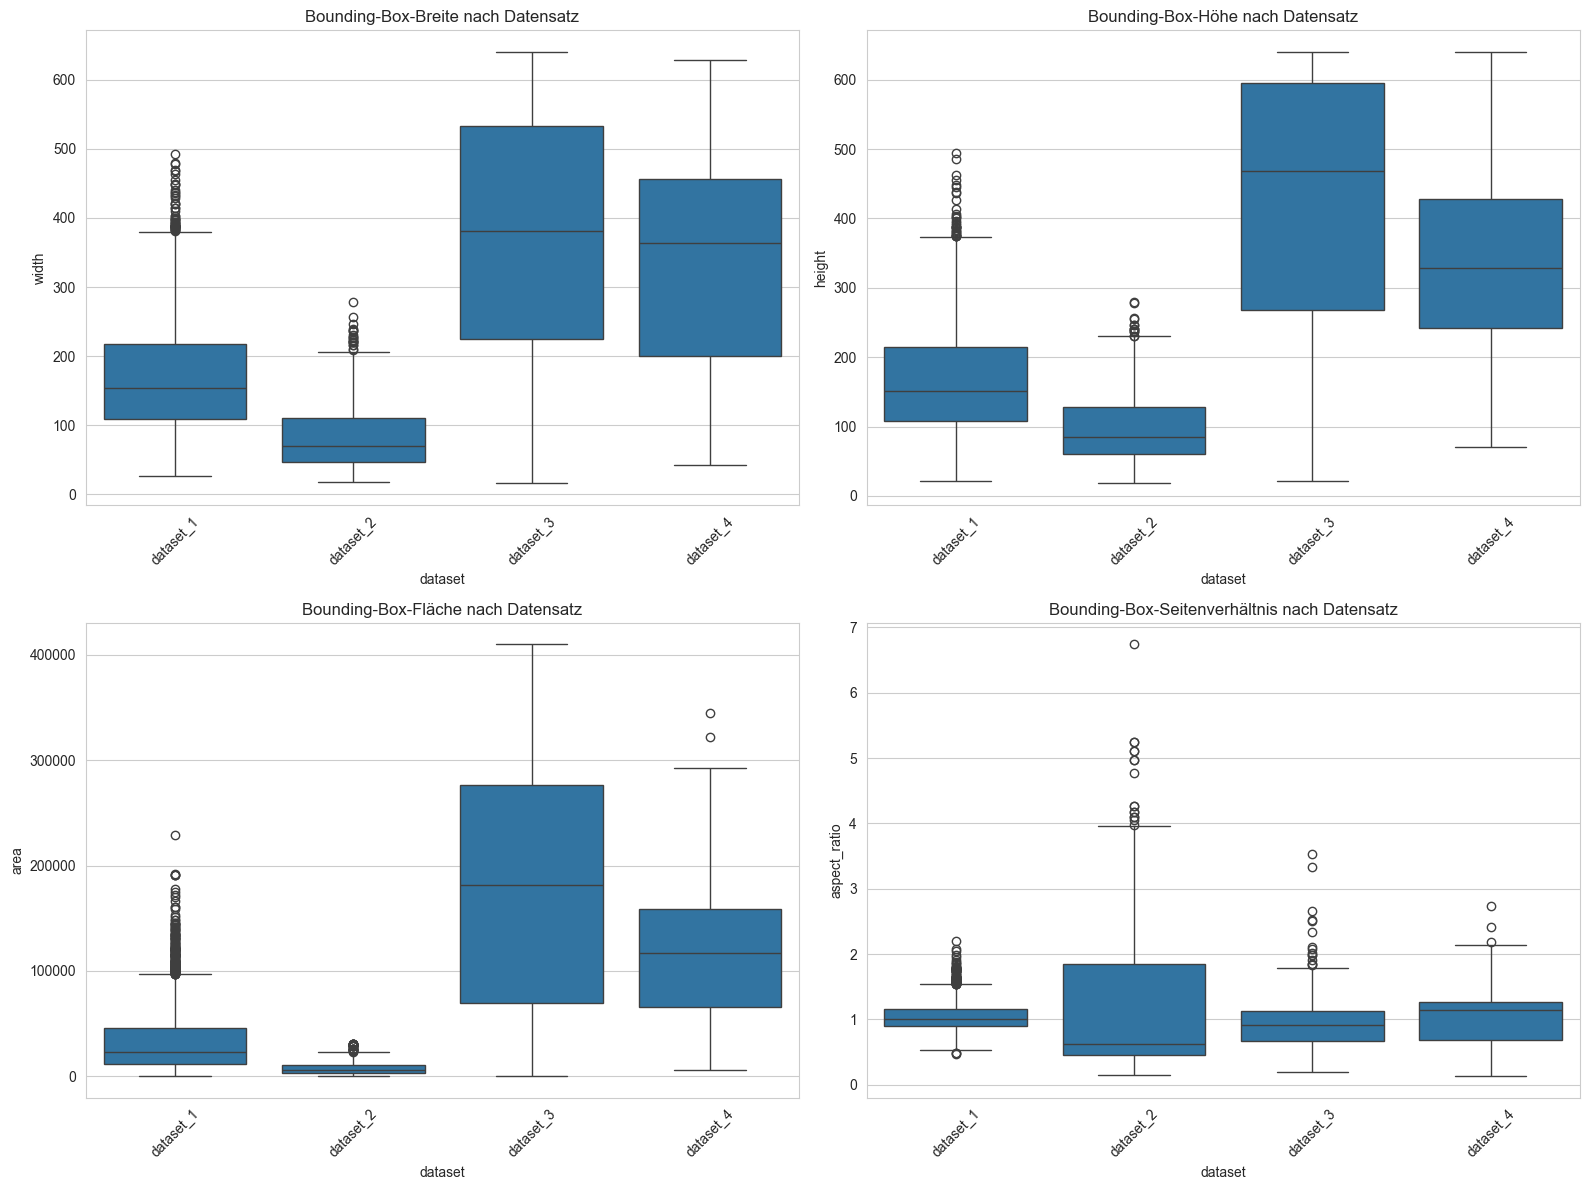

In [8]:
# 2. Box-Plots zum Vergleich der Dimensionen über Datensätze hinweg
if bbox_df is not None and 'dataset' in bbox_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Breite nach Datensatz
    sns.boxplot(x='dataset', y='width', data=bbox_df, ax=axes[0, 0])
    axes[0, 0].set_title('Bounding-Box-Breite nach Datensatz')
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
    
    # Höhe nach Datensatz
    sns.boxplot(x='dataset', y='height', data=bbox_df, ax=axes[0, 1])
    axes[0, 1].set_title('Bounding-Box-Höhe nach Datensatz')
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
    
    # Fläche nach Datensatz
    sns.boxplot(x='dataset', y='area', data=bbox_df, ax=axes[1, 0])
    axes[1, 0].set_title('Bounding-Box-Fläche nach Datensatz')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
    
    # Seitenverhältnis nach Datensatz
    sns.boxplot(x='dataset', y='aspect_ratio', data=bbox_df, ax=axes[1, 1])
    axes[1, 1].set_title('Bounding-Box-Seitenverhältnis nach Datensatz')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\463962189.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\463962189.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\463962189.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
C:\Users\fabud\AppData\Local\Temp\ipykernel_30804\463962189.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

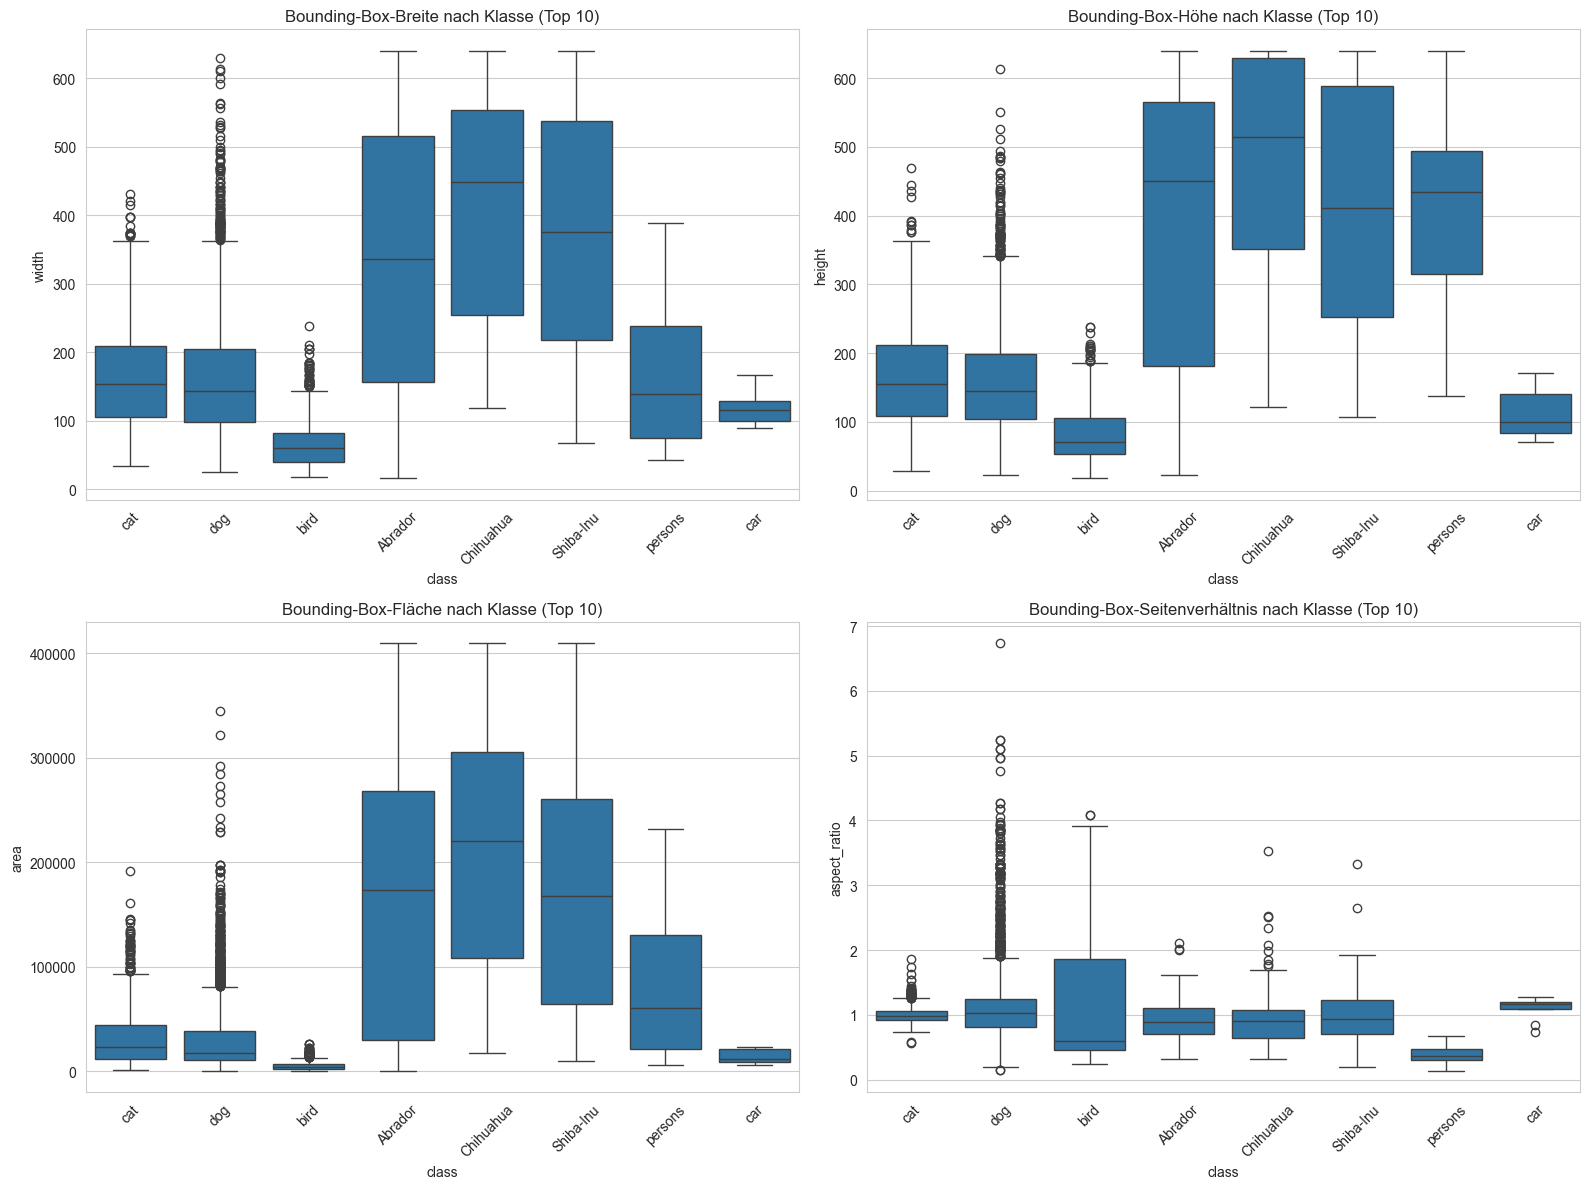

In [9]:
# 3. Box-Plots zum Vergleich der Dimensionen über Klassen hinweg
if bbox_df is not None and 'class' in bbox_df.columns:
    # Die häufigsten Klassen abrufen (Top 10)
    top_classes = [cls for cls, _ in class_distribution.most_common(10)]
    filtered_df = bbox_df[bbox_df['class'].isin(top_classes)]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Breite nach Klasse
    sns.boxplot(x='class', y='width', data=filtered_df, ax=axes[0, 0])
    axes[0, 0].set_title('Bounding-Box-Breite nach Klasse (Top 10)')
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
    
    # Höhe nach Klasse
    sns.boxplot(x='class', y='height', data=filtered_df, ax=axes[0, 1])
    axes[0, 1].set_title('Bounding-Box-Höhe nach Klasse (Top 10)')
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
    
    # Fläche nach Klasse
    sns.boxplot(x='class', y='area', data=filtered_df, ax=axes[1, 0])
    axes[1, 0].set_title('Bounding-Box-Fläche nach Klasse (Top 10)')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
    
    # Seitenverhältnis nach Klasse
    sns.boxplot(x='class', y='aspect_ratio', data=filtered_df, ax=axes[1, 1])
    axes[1, 1].set_title('Bounding-Box-Seitenverhältnis nach Klasse (Top 10)')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

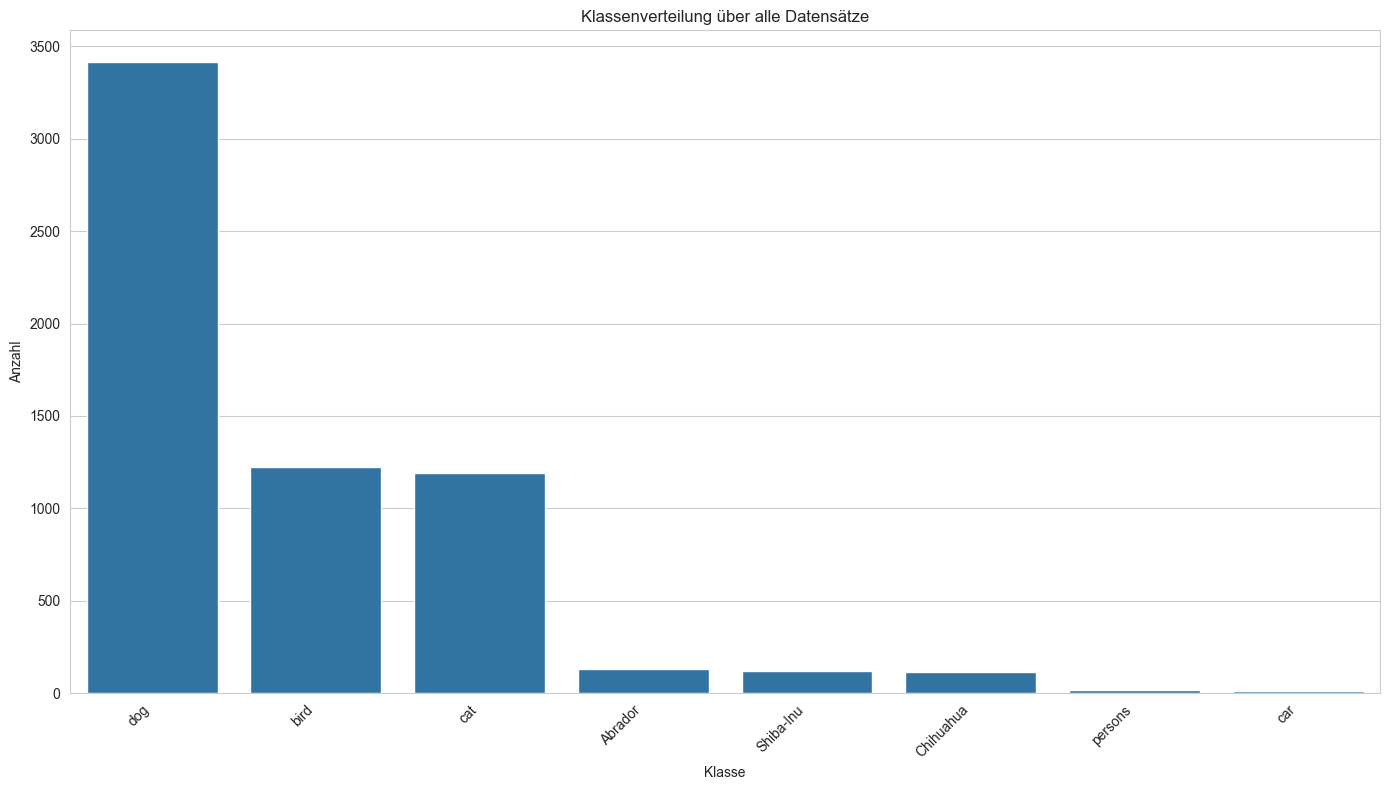

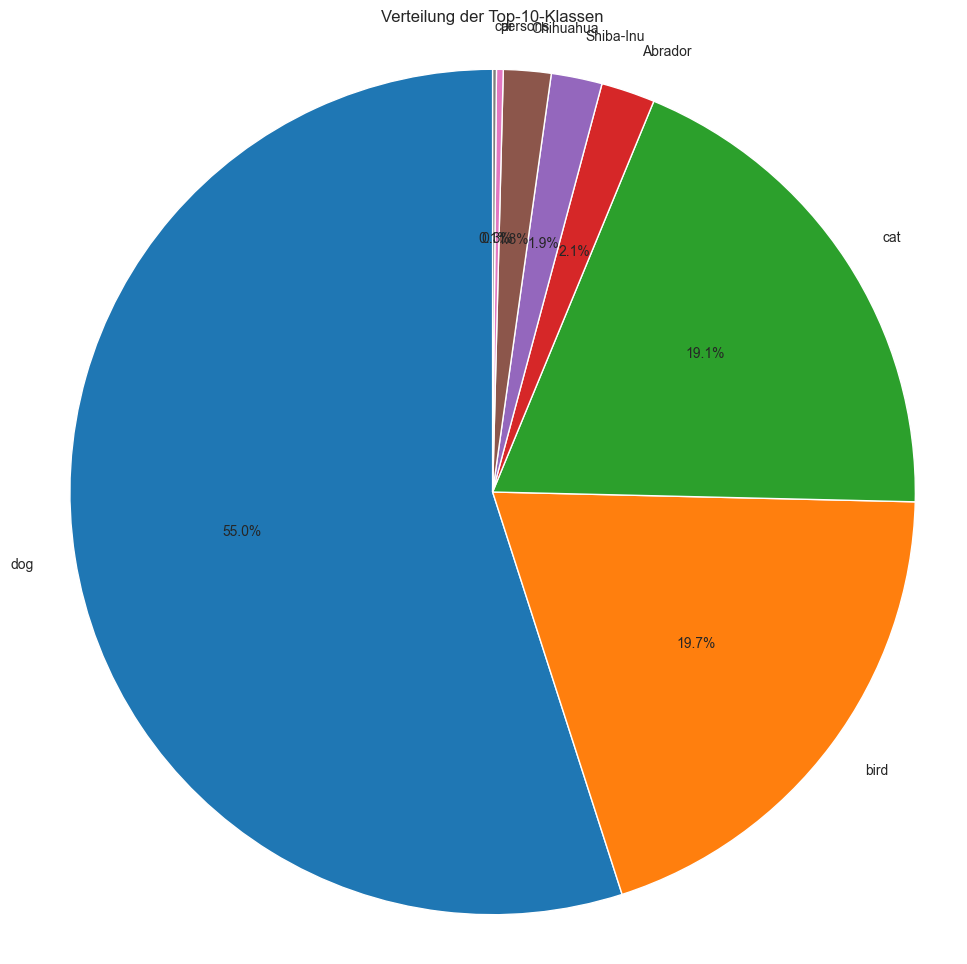

<Figure size 1400x800 with 0 Axes>

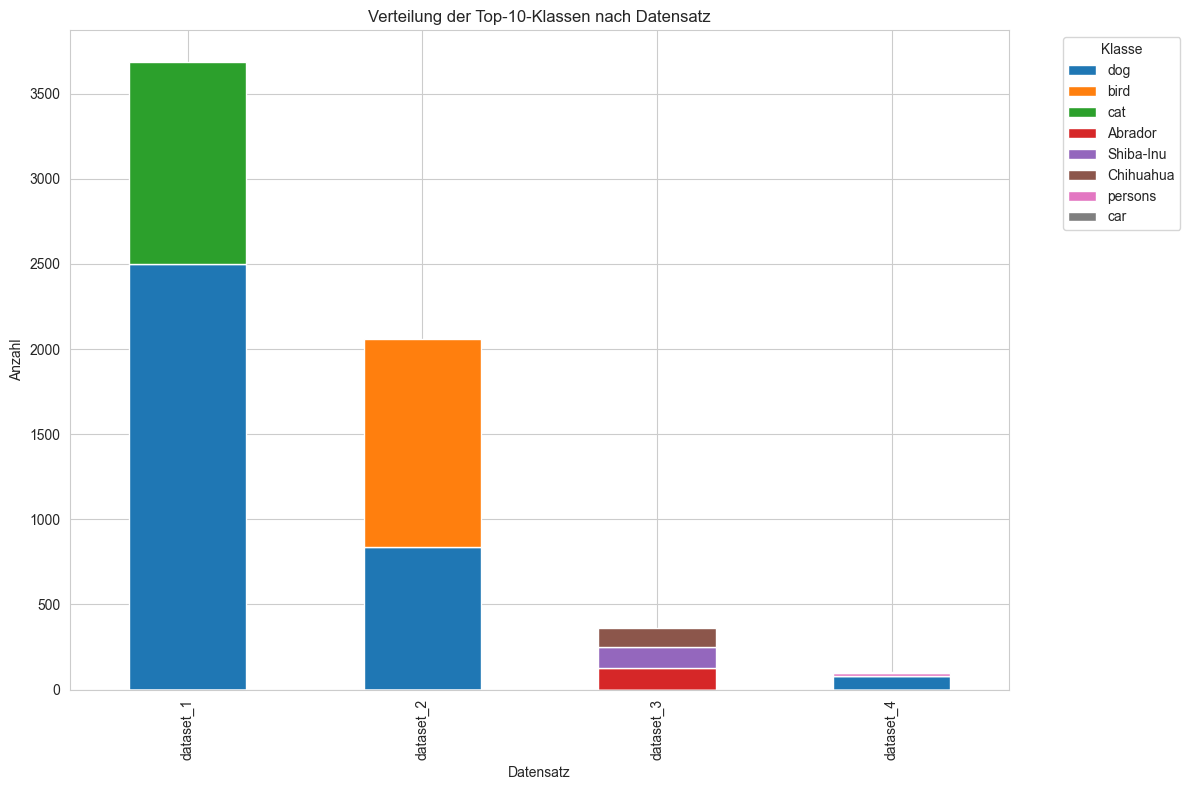

In [10]:
# 4. Klassenverteilungsvisualisierung
if class_distribution:
    # Balkendiagramm der Klassenhäufigkeiten
    plt.figure(figsize=(14, 8))
    class_names = [cls for cls, _ in class_distribution.most_common()]
    class_counts = [count for _, count in class_distribution.most_common()]
    
    sns.barplot(x=class_names, y=class_counts)
    plt.title('Klassenverteilung über alle Datensätze')
    plt.xlabel('Klasse')
    plt.ylabel('Anzahl')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Kreisdiagramm für die Top-10-Klassen
    plt.figure(figsize=(12, 12))
    top_classes = dict(class_distribution.most_common(10))
    other_count = sum(count for cls, count in class_distribution.items() if cls not in top_classes)
    if other_count > 0:
        top_classes['Andere'] = other_count
    
    plt.pie(top_classes.values(), labels=top_classes.keys(), autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Gleiches Seitenverhältnis stellt sicher, dass der Kreisdiagramm als Kreis dargestellt wird
    plt.title('Verteilung der Top-10-Klassen')
    plt.show()
    
    # Klassenverteilung nach Datensatz
    datasets = list(dataset_distribution.keys())
    top_classes = [cls for cls, _ in class_distribution.most_common(10)]
    
    class_counts_by_dataset = {}
    for cls in top_classes:
        class_counts_by_dataset[cls] = [dataset_distribution[ds].get(cls, 0) for ds in datasets]
    
    df_classes = pd.DataFrame(class_counts_by_dataset, index=datasets)
    
    plt.figure(figsize=(14, 8))
    df_classes.plot(kind='bar', stacked=True)
    plt.title('Verteilung der Top-10-Klassen nach Datensatz')
    plt.xlabel('Datensatz')
    plt.ylabel('Anzahl')
    plt.legend(title='Klasse', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

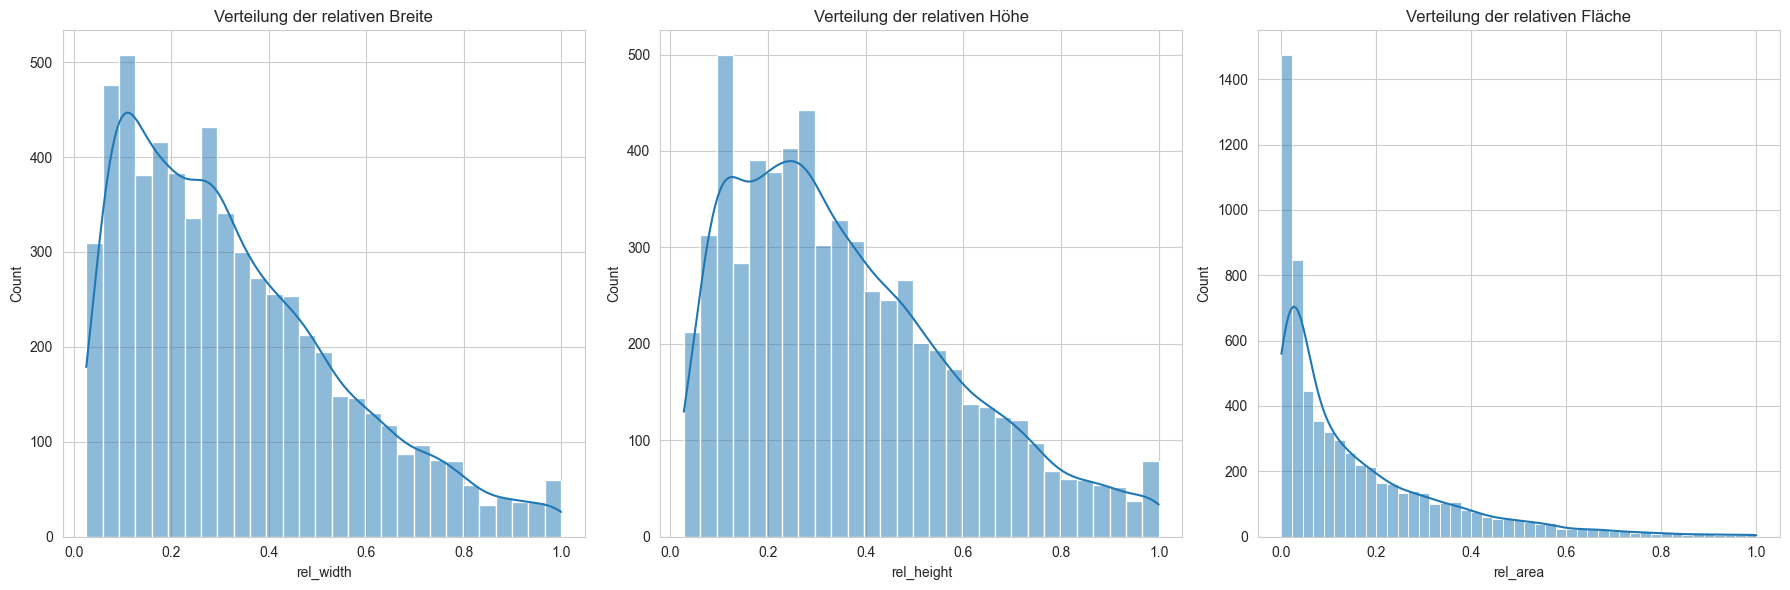

In [11]:
# 5. Analyse der relativen Größen
if bbox_df is not None and 'rel_width' in bbox_df.columns:
    # None-Werte herausfiltern
    rel_df = bbox_df.dropna(subset=['rel_width', 'rel_height', 'rel_area'])
    
    if not rel_df.empty:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Relative Breite
        sns.histplot(rel_df['rel_width'], kde=True, ax=axes[0])
        axes[0].set_title('Verteilung der relativen Breite')
        
        # Relative Höhe
        sns.histplot(rel_df['rel_height'], kde=True, ax=axes[1])
        axes[1].set_title('Verteilung der relativen Höhe')
        
        # Relative Fläche
        sns.histplot(rel_df['rel_area'], kde=True, ax=axes[2])
        axes[2].set_title('Verteilung der relativen Fläche')
        
        plt.tight_layout()
        plt.show()

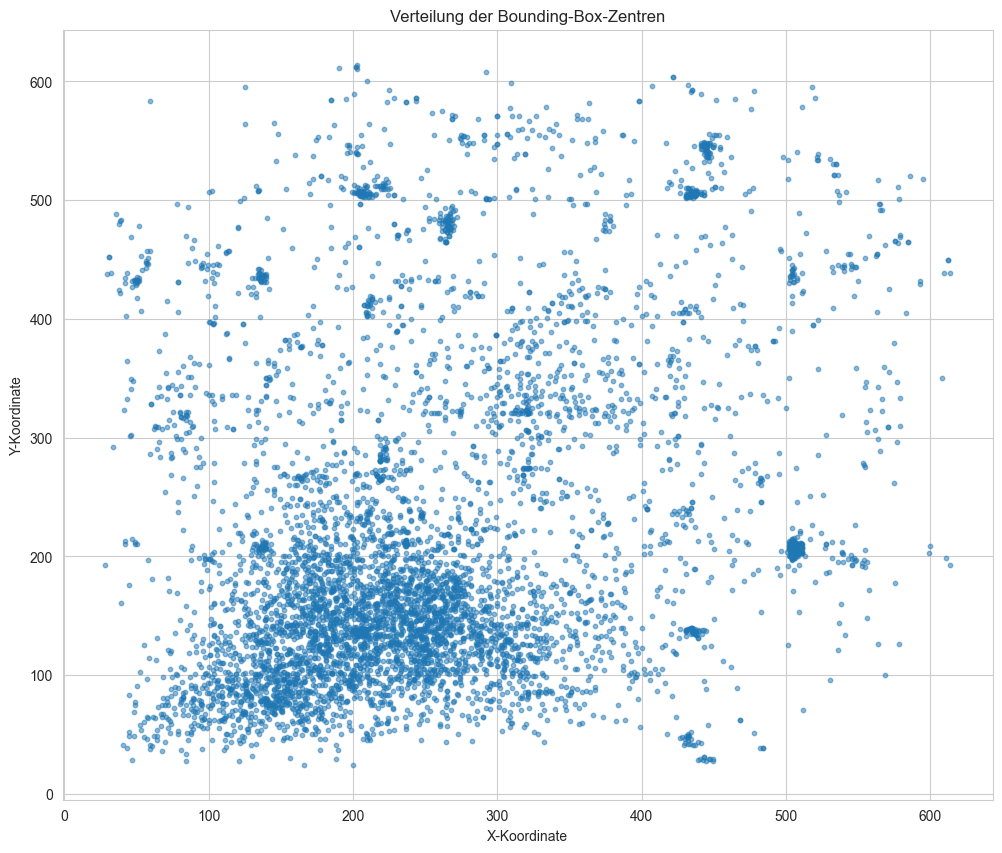

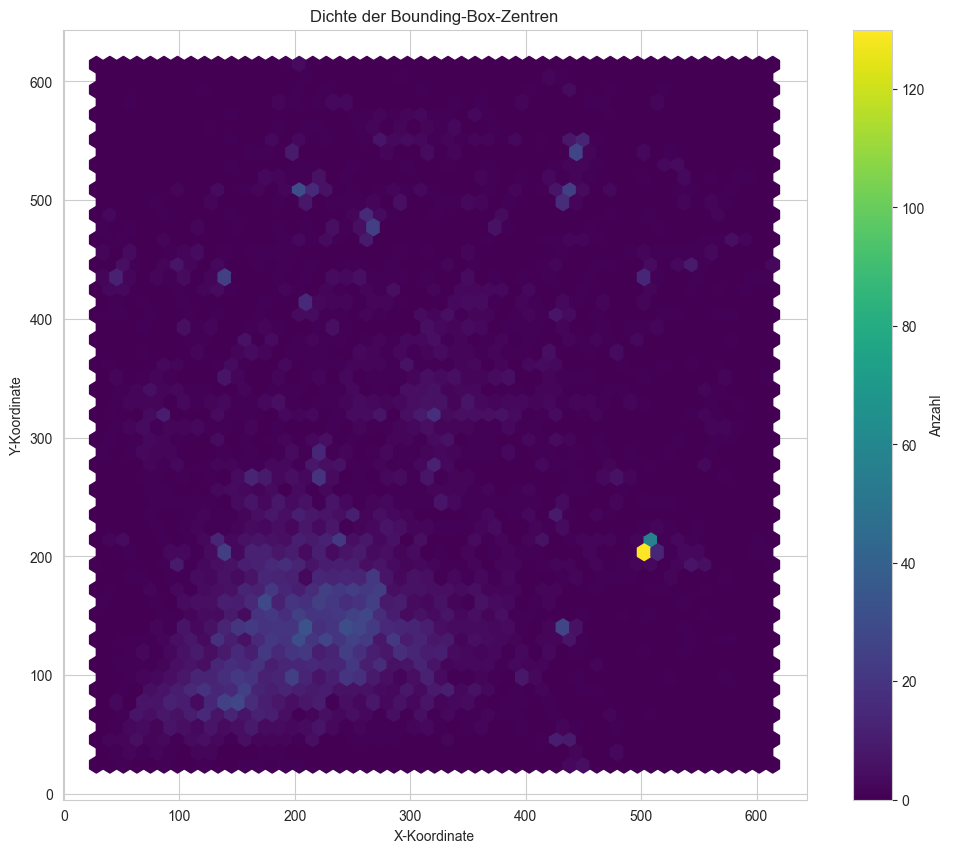

In [12]:
# 6. Analyse der Bounding-Box-Zentren
if bbox_df is not None and 'center_x' in bbox_df.columns and 'center_y' in bbox_df.columns:
    plt.figure(figsize=(12, 10))
    
    # Streudiagramm der Bounding-Box-Zentren
    plt.scatter(bbox_df['center_x'], bbox_df['center_y'], alpha=0.5, s=10)
    plt.title('Verteilung der Bounding-Box-Zentren')
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.grid(True)
    plt.show()
    
    # Hexagonen-Diagramm für bessere Dichtevisualisierung
    plt.figure(figsize=(12, 10))
    plt.hexbin(bbox_df['center_x'], bbox_df['center_y'], gridsize=50, cmap='viridis')
    plt.colorbar(label='Anzahl')
    plt.title('Dichte der Bounding-Box-Zentren')
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.grid(True)
    plt.show()

Gesamtzahl der eindeutigen Bilder: 5299

Bildgrößenstatistik:
         img_width   img_height
count  5299.000000  5299.000000
mean    489.993018   457.381015
std     126.474907   141.926998
min     114.000000   108.000000
25%     375.000000   333.000000
50%     500.000000   440.000000
75%     640.000000   640.000000
max     640.000000   640.000000


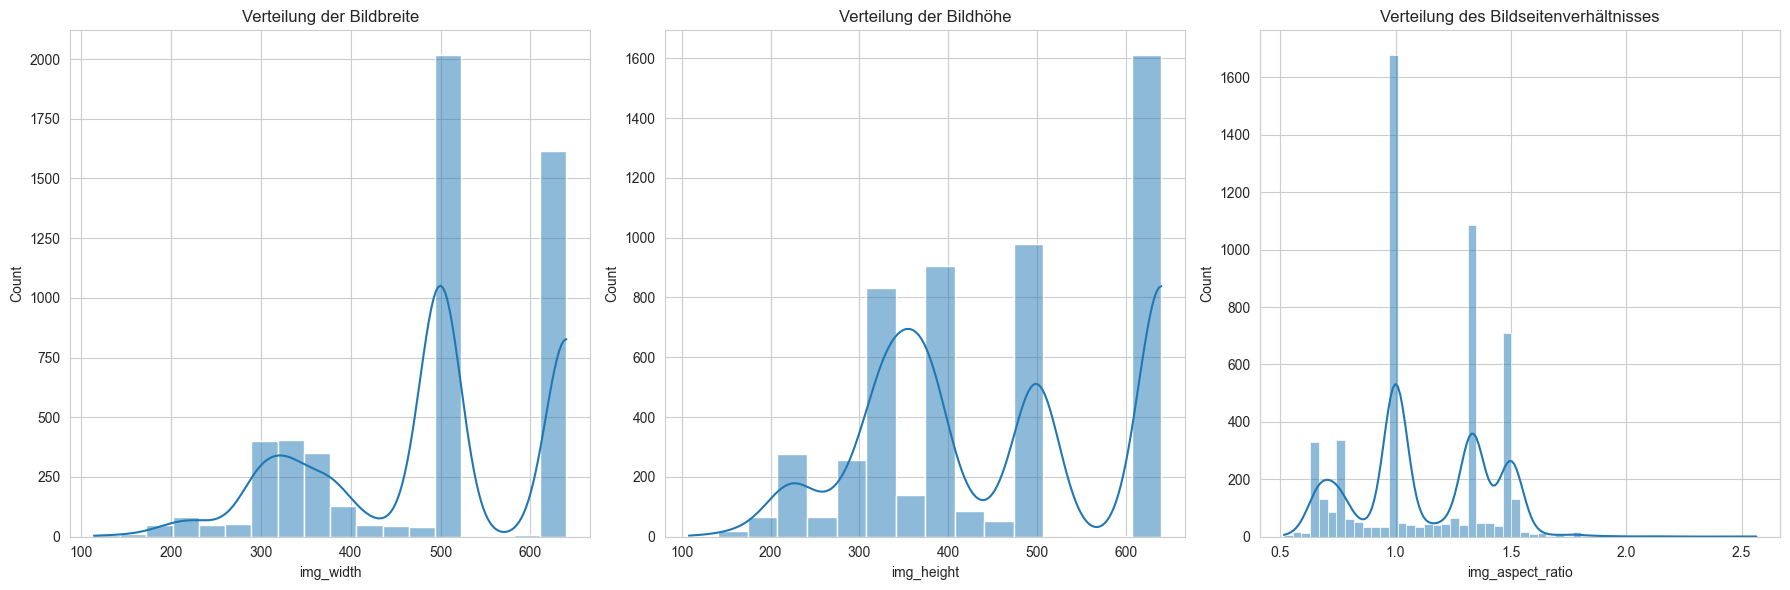

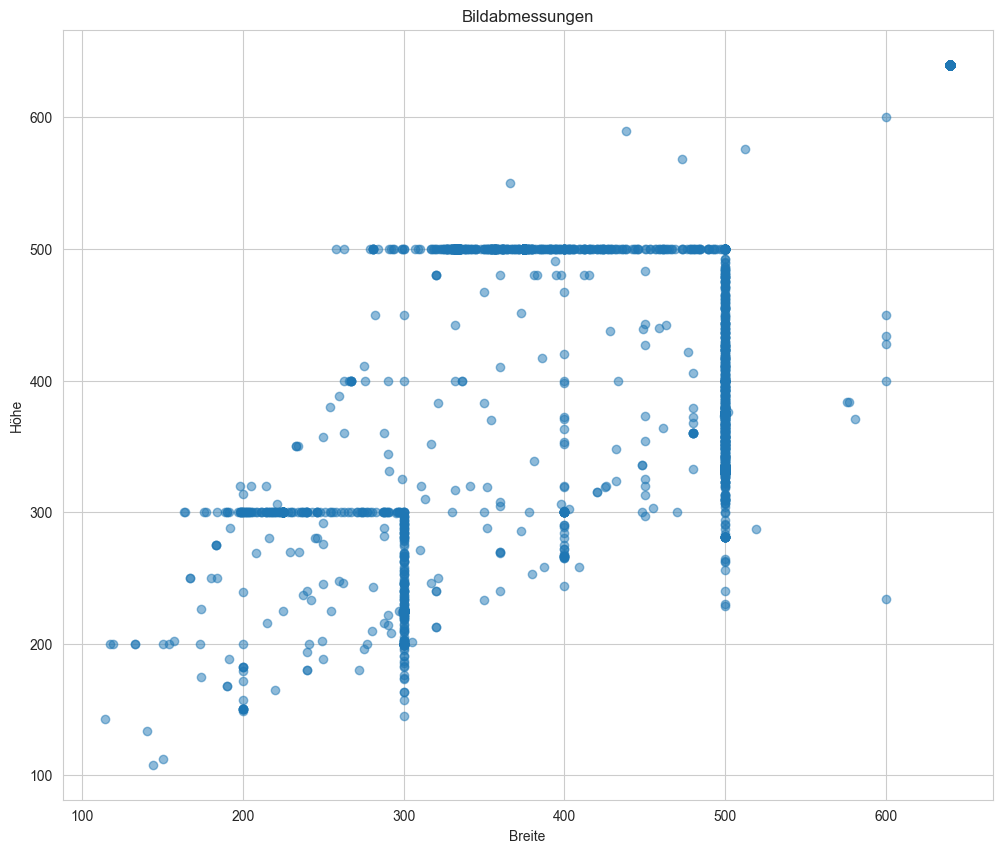

In [13]:
# 7. Bildgrößenanalyse
if bbox_df is not None and 'img_width' in bbox_df.columns and 'img_height' in bbox_df.columns:
    # Eindeutige Bildgrößen abrufen
    img_sizes = bbox_df[['file', 'img_width', 'img_height']].dropna().drop_duplicates()
    
    print(f"Gesamtzahl der eindeutigen Bilder: {len(img_sizes)}")
    print("\nBildgrößenstatistik:")
    print(img_sizes[['img_width', 'img_height']].describe())
    
    # Seitenverhältnis hinzufügen
    img_sizes['img_aspect_ratio'] = img_sizes['img_width'] / img_sizes['img_height']
    
    # Bildgrößen visualisieren
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Breite
    sns.histplot(img_sizes['img_width'], kde=True, ax=axes[0])
    axes[0].set_title('Verteilung der Bildbreite')
    
    # Höhe
    sns.histplot(img_sizes['img_height'], kde=True, ax=axes[1])
    axes[1].set_title('Verteilung der Bildhöhe')
    
    # Seitenverhältnis
    sns.histplot(img_sizes['img_aspect_ratio'], kde=True, ax=axes[2])
    axes[2].set_title('Verteilung des Bildseitenverhältnisses')
    
    plt.tight_layout()
    plt.show()
    
    # Streudiagramm der Bildabmessungen
    plt.figure(figsize=(12, 10))
    plt.scatter(img_sizes['img_width'], img_sizes['img_height'], alpha=0.5)
    plt.title('Bildabmessungen')
    plt.xlabel('Breite')
    plt.ylabel('Höhe')
    plt.grid(True)
    plt.show()